In [1]:
! pip install -U git+https://github.com/optuna/optuna.git -q

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/final-etarta/test_additional.csv
/kaggle/input/final-etarta/validation.csv
/kaggle/input/final-etarta/test.csv
/kaggle/input/final-etarta/train.csv/train.csv
/kaggle/input/preprocessed-citymobil/preprocessed_citymobil/train.csv
/kaggle/input/preprocessed-citymobil/preprocessed_citymobil/valid.csv
/kaggle/input/preprocessed-citymobil/preprocessed_citymobil/test.csv


In [161]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

def mean_absolute_percentage_error(y_true, y_pred):
    mask = (y_true != 0)
    return (np.fabs(y_true - y_pred) / y_true)[mask].mean() * 100

def calculate_metrics(y_true, y_pred):
    print(f"MAPE: {mean_absolute_percentage_error(y_true, y_pred)}")
    print(f"mse: {mean_squared_error(y_true, y_pred)}")
    print(f"r2: {r2_score(y_true, y_pred)}")

In [146]:
import gc
import json
from datetime import timedelta
from pathlib import Path

import category_encoders as ce

from joblib import dump
from tqdm.autonotebook import tqdm
tqdm.pandas()

In [5]:
data_path = Path('/') / 'kaggle' / 'input' / 'preprocessed-citymobil' / 'preprocessed_citymobil'

In [7]:
list(data_path.iterdir())

[PosixPath('/kaggle/input/preprocessed-citymobil/preprocessed_citymobil/train.csv'),
 PosixPath('/kaggle/input/preprocessed-citymobil/preprocessed_citymobil/valid.csv'),
 PosixPath('/kaggle/input/preprocessed-citymobil/preprocessed_citymobil/test.csv')]

In [8]:
train = pd.read_csv(data_path / 'train.csv')
valid = pd.read_csv(data_path / 'valid.csv')
test = pd.read_csv(data_path / 'test.csv')

In [9]:
train.head()

,Id,main_id_locality,ETA,RTA,OrderedDate,latitude,del_latitude,longitude,del_longitude,EDA,...,work_avg_speed_at_14,work_avg_speed_at_15,work_avg_speed_at_16,work_avg_speed_at_17,work_avg_speed_at_18,work_avg_speed_at_19,work_avg_speed_at_20,work_avg_speed_at_21,work_avg_speed_at_22,work_avg_speed_at_23
0,0,1078,226.0,188.0,2020-02-12 19:12:06,55.826019,55.825581,49.134529,49.126949,1.0,...,0.007848,0.007812,0.007144,0.00629,0.006826,0.008095,0.008686,0.009017,0.00931,0.009489
1,1,1078,718.0,725.0,2020-02-12 19:12:22,55.795502,55.820911,49.131470,49.115360,5.0,...,0.007848,0.007812,0.007144,0.00629,0.006826,0.008095,0.008686,0.009017,0.00931,0.009489
2,2,1078,612.0,764.0,2020-02-12 19:12:44,55.791050,55.819962,49.226070,49.176628,5.0,...,0.007848,0.007812,0.007144,0.00629,0.006826,0.008095,0.008686,0.009017,0.00931,0.009489
3,3,1078,1560.0,1412.0,2020-02-12 19:12:44,55.753899,55.824680,49.188519,49.093700,13.0,...,0.007848,0.007812,0.007144,0.00629,0.006826,0.008095,0.008686,0.009017,0.00931,0.009489
4,4,1078,1528.0,893.0,2020-02-12 19:12:45,55.822361,55.786758,49.069092,49.143501,9.0,...,0.007848,0.007812,0.007144,0.00629,0.006826,0.008095,0.008686,0.009017,0.00931,0.009489


In [14]:
def get_city_speed(x):
    if x['is_night']:
        return x[f"night_avg_speed_at_{x['hour']}"]
    
    if x['is_rush_hour']:
        return x[f"rush_avg_speed_at_{x['hour']}"]
    
    if x['is_weekend']:
        return x[f"weekend_avg_speed_at_{x['hour']}"]
    
    return x[f"work_avg_speed_at_{x['hour']}"]

In [15]:
def get_estimated_speed(x):
    return x['EDA'] / x['ETA']

In [16]:
def speed_preprocessing(df):
    df['current_city_speed'] = df.progress_apply(get_city_speed, axis=1)
    df['estimated_speed'] = df.apply(get_estimated_speed, axis=1)
    df['speed_difference'] = df['current_city_speed'] - df['estimated_speed']
    df['speed_ratio'] = df['current_city_speed'] / df['estimated_speed']
    df['detour_time'] = df['detour'] * df['estimated_speed']
    return df

In [17]:
train = speed_preprocessing(train)
valid = speed_preprocessing(valid)
test = speed_preprocessing(test)

In [18]:
set(train.columns) - set(test.columns)

{'ClientCollected',
 'GoodArrived',
 'RDA',
 'RTA',
 'ReadyForCollection',
 'arrived_latitude',
 'arrived_longitude',
 'onway_latitude',
 'onway_longitude',
 'ready_latitude',
 'ready_longitude',
 'route'}

Shuffle train

In [19]:
train = train.sample(frac=1)

In [187]:
columns_for_training = test.columns.difference(['Id', 'OrderedDate'])

In [188]:
X_train, y_train = train[columns_for_training], train['ETA'] - train['RTA']
X_valid, y_valid = valid[columns_for_training], valid['ETA'] - valid['RTA']

In [189]:
feature_names = list(X_train.columns)

In [190]:
categorical_columns = ['main_id_locality', 'day_of_week']
encoder = ce.OrdinalEncoder(cols=categorical_columns)

In [191]:
X_train = encoder.fit_transform(X_train)
X_valid = encoder.transform(X_valid)

In [192]:
from lightgbm import LGBMRegressor

In [193]:
clf = LGBMRegressor(
            n_estimators=4000,
            learning_rate=0.03,
            num_leaves=30,
            colsample_bytree=.8,
            subsample=.9,
            max_depth=7,
            reg_alpha=.3,
            reg_lambda=.1,
            min_split_gain=.01,
            min_child_weight=2,
            verbose=2,  
)

In [194]:
clf.fit(
        X_train, y_train, 
        eval_set= [(X_train, y_train), (X_valid, y_valid)], 
        eval_metric='rmse', verbose=100, early_stopping_rounds=500, 
        feature_name=feature_names, categorical_feature=categorical_columns
)

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1295: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['day_of_week', 'main_id_locality']



Training until validation scores don't improve for 500 rounds
[100]	training's rmse: 144.263	training's l2: 20811.7	valid_1's rmse: 167.96	valid_1's l2: 28210.6
[200]	training's rmse: 140.618	training's l2: 19773.5	valid_1's rmse: 163.854	valid_1's l2: 26848.2
[300]	training's rmse: 139.129	training's l2: 19356.9	valid_1's rmse: 162.497	valid_1's l2: 26405.4
[400]	training's rmse: 138.164	training's l2: 19089.3	valid_1's rmse: 161.738	valid_1's l2: 26159
[500]	training's rmse: 137.455	training's l2: 18893.9	valid_1's rmse: 161.269	valid_1's l2: 26007.6
[600]	training's rmse: 136.862	training's l2: 18731.1	valid_1's rmse: 160.837	valid_1's l2: 25868.6
[700]	training's rmse: 136.326	training's l2: 18584.7	valid_1's rmse: 160.53	valid_1's l2: 25770
[800]	training's rmse: 135.855	training's l2: 18456.5	valid_1's rmse: 160.275	valid_1's l2: 25688.1
[900]	training's rmse: 135.452	training's l2: 18347.3	valid_1's rmse: 160.061	valid_1's l2: 25619.5
[1000]	training's rmse: 135.072	training's l

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
              importance_type='split', learning_rate=0.03, max_depth=7,
              min_child_samples=20, min_child_weight=2, min_split_gain=0.01,
              n_estimators=4000, n_jobs=-1, num_leaves=30, objective=None,
              random_state=None, reg_alpha=0.3, reg_lambda=0.1, silent=True,
              subsample=0.9, subsample_for_bin=200000, subsample_freq=0,
              verbose=2)

In [172]:
def calculate_valid_metrics(clf, prefix=''):
    clf_name = f"{prefix}_{clf.__class__.__name__}"
    print(f'Evaluating {clf_name}')
    if hasattr(clf, 'booster_'):
        clf.booster_.save_model(f'{clf_name}.txt')
    elif hasattr(clf, 'save_model'):
        clf.save_model(f'{clf_name}.txt')
    dump(clf, f"{clf_name}.joblib")
    
    y_valid_pred = clf.predict(X_valid)
    print(f"Prediction diff: {y_valid_pred.mean()},\tTrue diff: {(valid['ETA'] - valid['RTA']).mean()}", end='\t')
    prediction_diff_bias = (valid['ETA'] - valid['RTA']).mean() - y_pred.mean()
    print(f'Difference: {prediction_diff_bias}')
    
    valid['pred_diff'] = y_valid_pred
    valid['pred'] = valid['ETA'] - y_valid_pred
    
    prediction_diff_by_group = valid.groupby(by='main_id_locality').apply(lambda x: (x['ETA'] - x['RTA']).mean() - x['pred_diff'].mean()).to_frame(name = 'diff').reset_index()
    print(prediction_diff_by_group)
    
    print("Diff metrics")
    calculate_metrics(y_valid, y_valid_pred)
    
    print("True RTA metrics")
    calculate_metrics(valid['RTA'], valid['pred'])
    
    print("True RTA metrics with bias substracting")
    calculate_metrics(valid['RTA'], valid['pred'] - prediction_diff_bias)
    
    print("True RTA metrics with bias substracting by group")
    calculate_metrics(valid['RTA'], valid['pred'] - valid.merge(prediction_diff_by_group)['diff'])
    
    return prediction_diff_bias, prediction_diff_by_group

In [195]:
prediction_diff_bias, prediction_diff_by_group = calculate_valid_metrics(clf, prefix='simple')

Evaluating simple_LGBMRegressor
Prediction diff: 171.87178228131197,	True diff: 199.24604850326577	Difference: 38.944602401133636
   main_id_locality       diff
0              1078  32.469686
1             22390  14.322170
2             22430  10.569270
3             22438  39.700132
Diff metrics
MAPE: 20.78274161531334
mse: 24988.41902534247
r2: 0.543787210474025
True RTA metrics
MAPE: 15.597789255323868
mse: 24988.41902534247
r2: 0.8755541483583447
True RTA metrics with bias substracting
MAPE: 14.210718679831047
mse: 24372.94125345131
r2: 0.878619314482373
True RTA metrics with bias substracting by group
MAPE: 14.38538835169182
mse: 24114.087086932606
r2: 0.8799084447459059


In [196]:
def prepate_test_submsission(clf, prediction_diff_bias, prediction_diff_by_group, prefix):
    prefix = Path(prefix)
    prefix.mkdir(exist_ok=True)
    
    X_test = test[columns_for_training]
    X_test = encoder.transform(X_test)
    
    test_pred = clf.predict(X_test)
    print(f"Mean of diff on test is {test_pred.mean()}")
    
    submission = test[['Id']].copy()
    
    submission['Prediction'] = test['ETA'] - test_pred
    submission.to_csv(prefix / "submission_pure.csv", index=False)
    
    submission['Prediction'] = test['ETA'] - test_pred - prediction_diff_bias
    submission.to_csv(prefix / "submission_without_bias.csv", index=False)
    
    submission['Prediction'] += valid['pred_diff'].mean() - test_pred.mean()
    submission.to_csv(prefix / "submission_without_bias_corrected.csv", index=False)
    
    submission['main_id_locality'] = test['main_id_locality']
    submission['Prediction'] = submission['Prediction'] - test.merge(prediction_diff_by_group)['diff']
    submission.drop(columns='main_id_locality', inplace=True)
    submission.to_csv(prefix / "submission_without_bias_grouped.csv", index=False)
    
    submission['Prediction'] += valid['pred_diff'].mean() - test_pred.mean()
    submission.to_csv(prefix / "submission_without_bias_grouped_corrected.csv", index=False)

In [197]:
prepate_test_submsission(clf, prediction_diff_bias, prediction_diff_by_group, prefix='simple')

Mean of diff on test is 169.12474489002702


# HPO

In [87]:
import optuna
import optuna.integration.lightgbm as lgb
optuna.__version__

'1.3.0'

In [105]:
d_train = lgb.Dataset(X_train, label=y_train, feature_name=feature_names, categorical_feature=categorical_columns, free_raw_data=False)
d_valid = lgb.Dataset(X_valid, label=y_valid, feature_name=feature_names, categorical_feature=categorical_columns, free_raw_data=False)
gc.collect()

135

In [106]:
boosting_static_params = {
        "objective": "regression",
        "metric": "l2",
        "verbosity": 0,
        # "boosting_type": "gbdt",
}

In [107]:
study = optuna.create_study(direction="minimize")

In [108]:
time_to_train = timedelta(hours=6).seconds

In [109]:
model = lgb.train(
        params=boosting_static_params, 
        train_set=d_train, valid_sets=[d_valid], 
        early_stopping_rounds=100, num_boost_round=2000,
        verbose_eval=0, 
        study=study, time_budget=time_to_train,
        model_dir='/kaggle/working/boostings',
    )

/opt/conda/lib/python3.6/site-packages/optuna/_experimental.py:90: ExperimentalWarning:

train is experimental (supported from v0.18.0). The interface can change in the future.



  0%|          | 0/7 [00:00<?, ?it/s]

feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.

[I 2020-04-25 23:16:14,871] The booster of trial#0 was saved as /kaggle/working/boostings/0.pkl.


feature_fraction, val_score: 28589.812242:   0%|          | 0/7 [01:01<?, ?it/s]

feature_fraction, val_score: 28589.812242:  14%|#4        | 1/7 [01:01<06:10, 61.81s/it][I 2020-04-25 23:16:15,168] Finished trial#0 with value: 28589.812242486652 with parameters: {'feature_fraction': 0.6}. Best is trial#0 with value: 28589.812242486652.


feature_fraction, val_score: 28589.812242:  14%|#4        | 1/7 [01:02<06:10, 61.81s/it][I 2020-04-25 23:16:48,249] The booster of trial#1 was saved as /ka

num_leaves, val_score: 26815.375784:  40%|####      | 8/20 [05:21<08:13, 41.14s/it][I 2020-04-25 23:25:32,003] Finished trial#14 with value: 27706.46789216234 with parameters: {'num_leaves': 254}. Best is trial#8 with value: 26815.375784416705.


num_leaves, val_score: 26815.375784:  40%|####      | 8/20 [05:22<08:13, 41.14s/it][I 2020-04-25 23:26:07,399] The booster of trial#15 was saved as /kaggle/working/boostings/15.pkl.


num_leaves, val_score: 26815.375784:  40%|####      | 8/20 [05:57<08:13, 41.14s/it]

num_leaves, val_score: 26815.375784:  45%|####5     | 9/20 [05:57<07:14, 39.51s/it][I 2020-04-25 23:26:07,717] Finished trial#15 with value: 27496.822391265367 with parameters: {'num_leaves': 99}. Best is trial#8 with value: 26815.375784416705.


num_leaves, val_score: 26815.375784:  45%|####5     | 9/20 [05:57<07:14, 39.51s/it][I 2020-04-25 23:26:47,263] The booster of trial#16 was saved as /kaggle/working/boostings/16.pkl.


num_leaves, val_score: 26815.375784:  45%|####5     |

In [139]:
dump(study, "study.joblib")

['study.joblib']

In [174]:
prediction_diff_bias, prediction_diff_by_group = calculate_valid_metrics(model, prefix='hpo')

Evaluating hpo_Booster
Prediction diff: 159.13281519110015,	True diff: 199.24604850326577	Difference: 38.944602401133636
   main_id_locality       diff
0              1078  36.871802
1             22390  22.473296
2             22430  25.772024
3             22438  67.981891
Diff metrics
MAPE: 24.45787280400099
mse: 26815.375784416712
r2: 0.510432517703934
True RTA metrics
MAPE: 16.7249351963304
mse: 26815.375784416712
r2: 0.8664556459855097
True RTA metrics with bias substracting
MAPE: 14.668524429692498
mse: 25207.6699958667
r2: 0.8744622475973372
True RTA metrics with bias substracting by group
MAPE: 14.648584602996891
mse: 24917.982432967427
r2: 0.8759049325242401


In [167]:
prepate_test_submsission(model, prediction_diff_bias, prediction_diff_by_group, prefix='hpo')

Mean of diff on test is 156.75964487874307


Retrain on full dataset

In [147]:
print('Best parameters: ' + json.dumps(study.best_params, indent=4))

Best parameters: {
    "num_leaves": 118
}


In [149]:
import lightgbm as original_lightgbm

In [170]:
model_retrained = original_lightgbm.train(
    params={**boosting_static_params, **best_params, 'learning_rate': 0.03}, 
    train_set=d_train, valid_sets=[d_valid],
    feature_name=feature_names, categorical_feature=categorical_columns,
    init_model=model,
    verbose_eval=400,
    early_stopping_rounds=600, num_boost_round=4000)

Training until validation scores don't improve for 600 rounds
[400]	valid_0's l2: 26776.6
[800]	valid_0's l2: 26681
[1200]	valid_0's l2: 26594.6
[1600]	valid_0's l2: 26632.7
Early stopping, best iteration is:
[1262]	valid_0's l2: 26568.4


In [175]:
prediction_diff_bias, prediction_diff_by_group = calculate_valid_metrics(model_retrained, prefix='hpo_retrained')

Evaluating hpo_retrained_Booster
Prediction diff: 163.15664877835286,	True diff: 199.24604850326577	Difference: 38.944602401133636
   main_id_locality       diff
0              1078  38.728418
1             22390  12.971572
2             22430  12.363705
3             22438  64.505983
Diff metrics
MAPE: 23.700690028785083
mse: 26568.396911212676
r2: 0.514941603316118
True RTA metrics
MAPE: 16.402208230273907
mse: 26568.396911212676
r2: 0.867685635613193
True RTA metrics with bias substracting
MAPE: 14.622438685061148
mse: 25274.104321030427
r2: 0.8741313952867187
True RTA metrics with bias substracting by group
MAPE: 14.636234121676528
mse: 24872.8209495234
r2: 0.8761298430823227


In [178]:
prepate_test_submsission(model_retrained, prediction_diff_bias, prediction_diff_by_group, prefix='hpo_retrained')

Mean of diff on test is 159.98636645890878


# Feature importance

In [177]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [220]:
def plot_importance(model, importance_type='split'):
    """
    importance_type could be split or 'gain'
    """
    feat_importance = pd.DataFrame()
    feat_importance["feature"] = X_train.columns
    feat_importance[importance_type] = model.feature_importance(importance_type=importance_type)
    feat_importance = feat_importance.sort_values(by=importance_type, ascending=False).head(20)
    plt.figure(figsize=(20, 10))
    ax = sns.barplot(y="feature", x=importance_type, data=feat_importance)

In [222]:
plot_importance(model_retrained, importance_type='split')

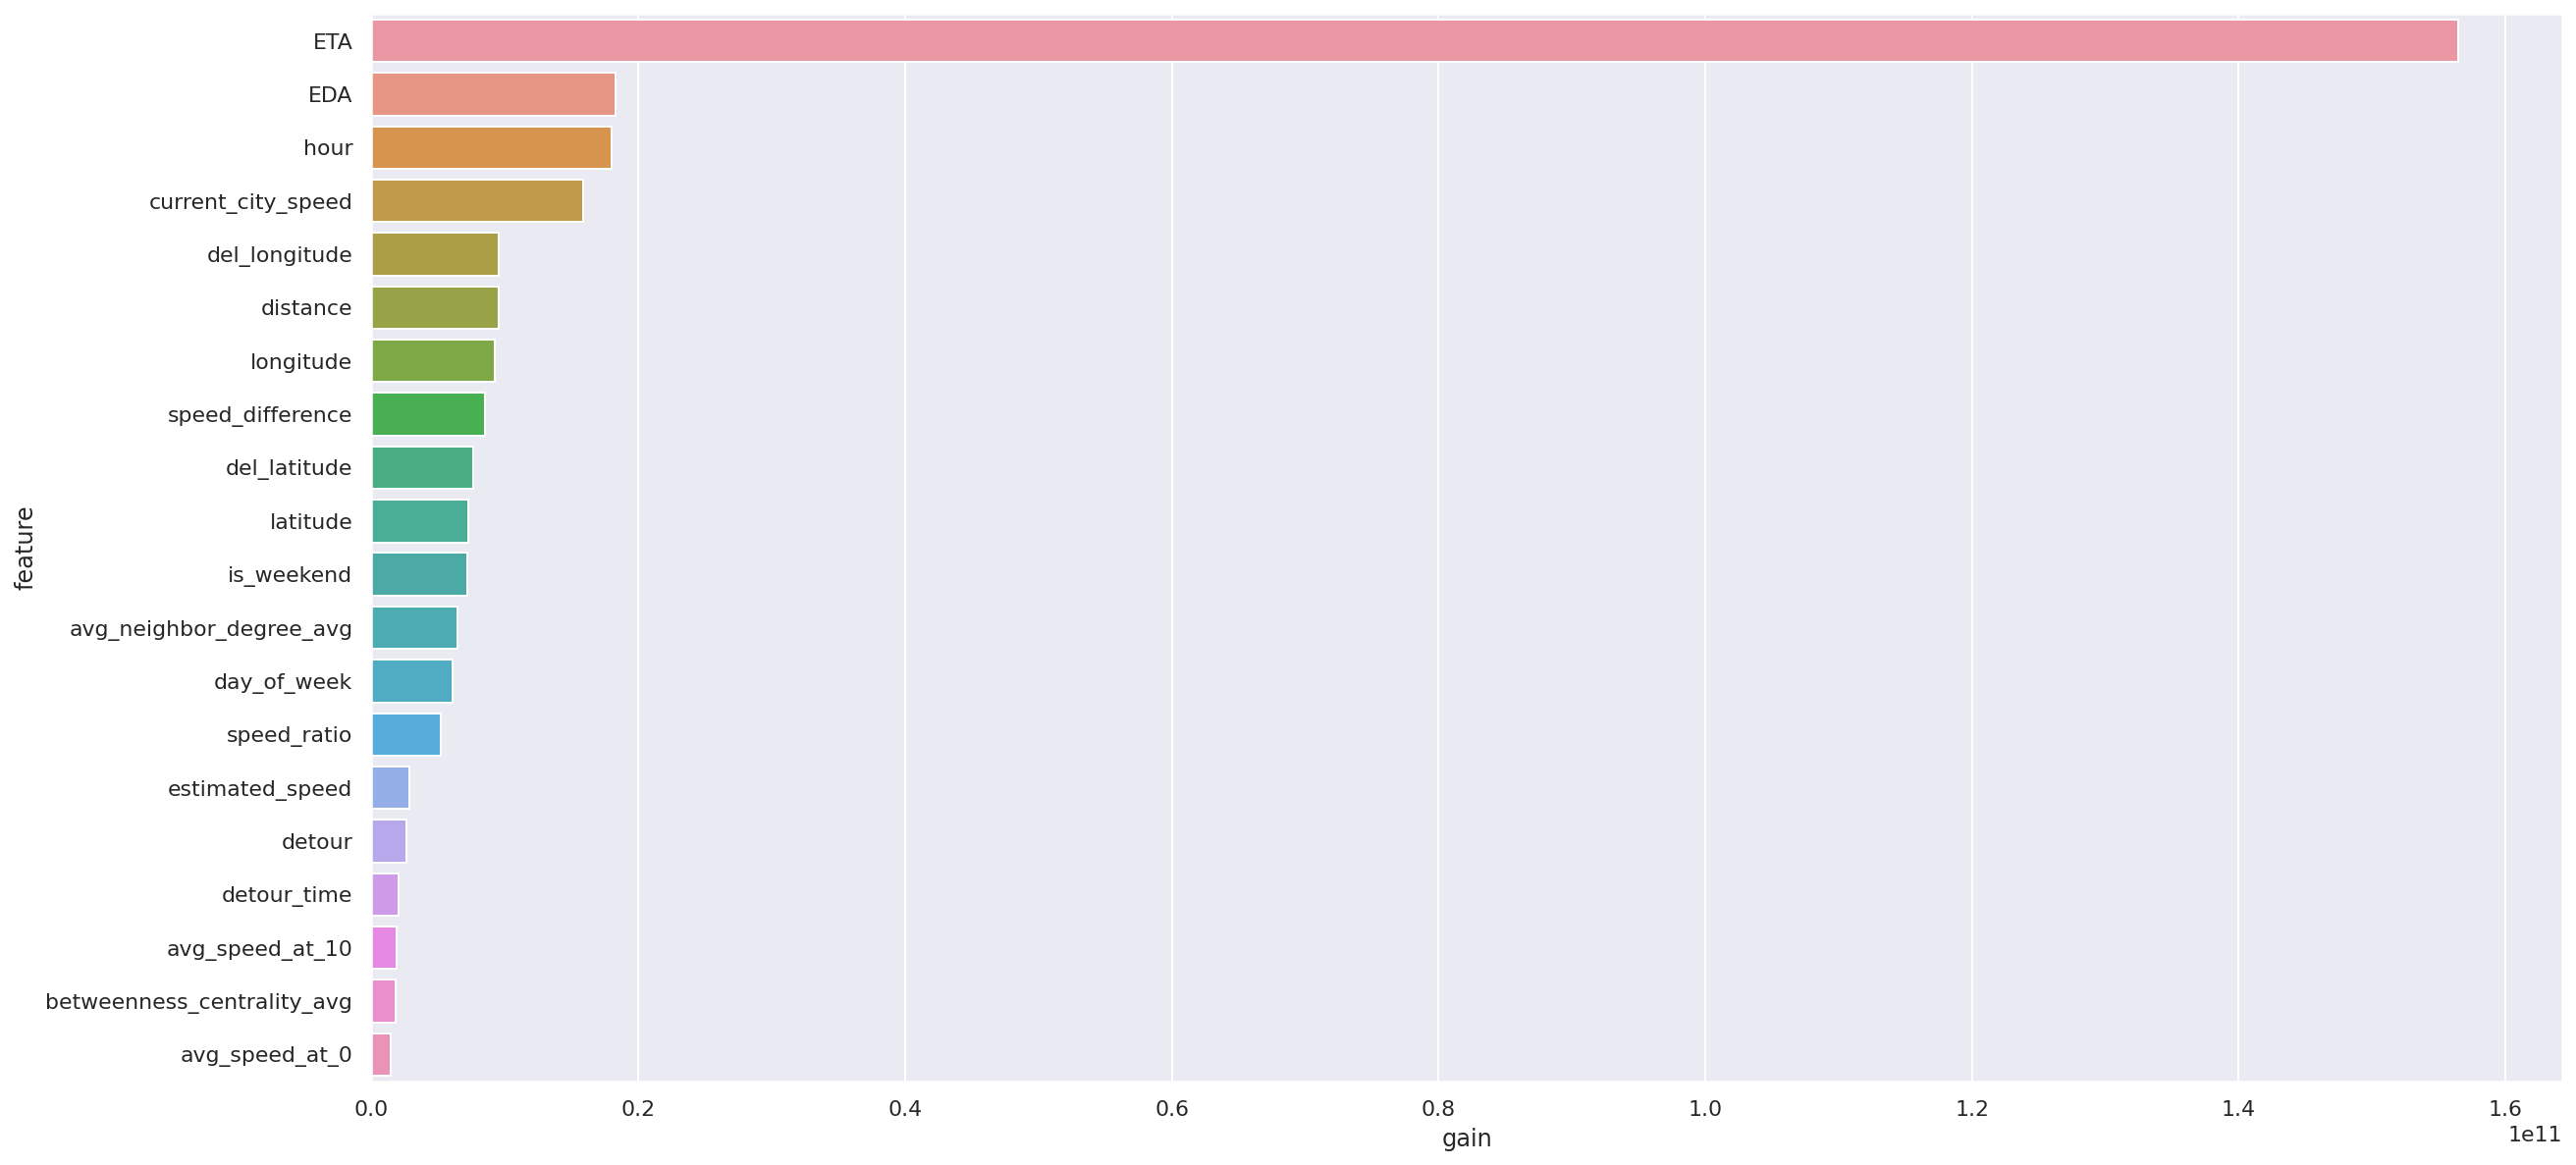

In [219]:
plot_importance(model_retrained, importance_type='gain')